In [2]:
%load_ext autoreload
%autoreload 2

In [43]:
import numpy as np
import rasterio
from rasterio.plot import show as rio_show
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
import glob
from datetime import datetime

In [135]:
gps_folder = '../data/GPS/'
data = None

for fname in glob.glob(gps_folder + '*'):
    if data is None:
        data = pd.read_csv(fname)
    else:
        data = data.append(pd.read_csv(fname))
            
# print(data)
date1_list = [datetime.strptime(i, '%Y-%m-%d') for i in data['date1']]
data['date1_obj'] = date1_list
date2_list = [datetime.strptime(i, '%Y-%m-%d') for i in data['date2']]
data['date2_obj'] = date2_list
datec_list = [j + (i - j) / 2 for i, j in zip(date1_list, date2_list)]
data['datec_obj'] = datec_list
dated_list = [(i - j) / 2 for i, j in zip(date1_list, date2_list)]
data['dated_obj'] = dated_list
tag_list = ['--' for i in data['date1']]
data['sat_tag'] = tag_list

data['carst_velo_x (m/d)'] = [np.nan for i in data['date1']]
data['carst_velo_y (m/d)'] = [np.nan for i in data['date1']]
data['carst_velo (m/d)'] = [np.nan for i in data['date1']]

# print(data)

In [136]:
carst_folder = '../data/CARST/'

for fname in glob.glob(carst_folder + '*'):
    raster = rasterio.open(fname)
    ftag = fname.split('_')[0].split('/')[-1]
    fdate1 = fname.split('_')[1].split('-')[-1]
    fdate2 = fname.split('_')[1].split('-')[0]
    fcomp = fname.split('_')[3]
    fdate1_obj = datetime.strptime(fdate1, '%Y%m%d')
    fdate2_obj = datetime.strptime(fdate2, '%Y%m%d')
    # print(ftag, fdate1, fdate2)
    
    data_subset = data.loc[(data['date1_obj'] == fdate1_obj) & (data['date2_obj'] == fdate2_obj)]
    samp_locs = gpd.GeoDataFrame(data_subset, geometry=gpd.points_from_xy(data_subset['end_easting'], data_subset['end_northing']), crs='EPSG:32607')
    samp_xy = list(samp_locs[['end_easting', 'end_northing']].to_records(index=False))
    velocomp = []
    for pt_xy in samp_xy:
        # print(pt_xy)
        # print(type(pt_xy.tolist()))
        if np.any(np.isnan(pt_xy.tolist())):
            velocomp_tmp = [np.nan]
        else:
            samp_gen = raster.sample([pt_xy])
            velocomp_tmp = [float(record) for record in samp_gen]
        velocomp.append(velocomp_tmp[0])
    if fcomp == 'vx':
        data.loc[(data['date1_obj'] == fdate1_obj) & (data['date2_obj'] == fdate2_obj), 'carst_velo_x (m/d)'] = velocomp
    elif fcomp == 'vy':
        data.loc[(data['date1_obj'] == fdate1_obj) & (data['date2_obj'] == fdate2_obj), 'carst_velo_y (m/d)'] = velocomp
    else:
        print('You should not see this text -- something is wong!!')
    data.loc[(data['date1_obj'] == fdate1_obj) & (data['date2_obj'] == fdate2_obj), 'sat_tag'] = ftag

#     print(samp_xy)
#     samp_gen = raster.sample(samp_xy)
#     velocomp = [float(record) for record in samp_gen]

In [139]:
data_filt = data[(data['carst_velo_x (m/d)'] > -1000) & (data['velocity (m/d)'] > -1000)]
carst_vx = data_filt['carst_velo_x (m/d)'].values
carst_vy = data_filt['carst_velo_y (m/d)'].values
carst_v = np.sqrt(carst_vx ** 2 + carst_vy ** 2)
carst_v.tolist()
# data_filt['carst_velo (m/d)']
data_filt['carst_velo (m/d)'] = carst_v.tolist()
# print(carst_v.tolist())
# data_filt.shape
data_filt['velocity (m/d)'] = -data_filt['velocity (m/d)']
# data_filt

/data/whyj/Software/anaconda3/envs/carst/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/data/whyj/Software/anaconda3/envs/carst/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [141]:
pt0 = data_filt.loc[data_filt['Unnamed: 0'] == 0].sort_values(by=['date1_obj'])
pt1 = data_filt.loc[data_filt['Unnamed: 0'] == 1].sort_values(by=['date1_obj'])
pt2 = data_filt.loc[data_filt['Unnamed: 0'] == 2].sort_values(by=['date1_obj'])


In [193]:
# pt2
# pt0


Text(0.5, 1.0, 'Pt left')

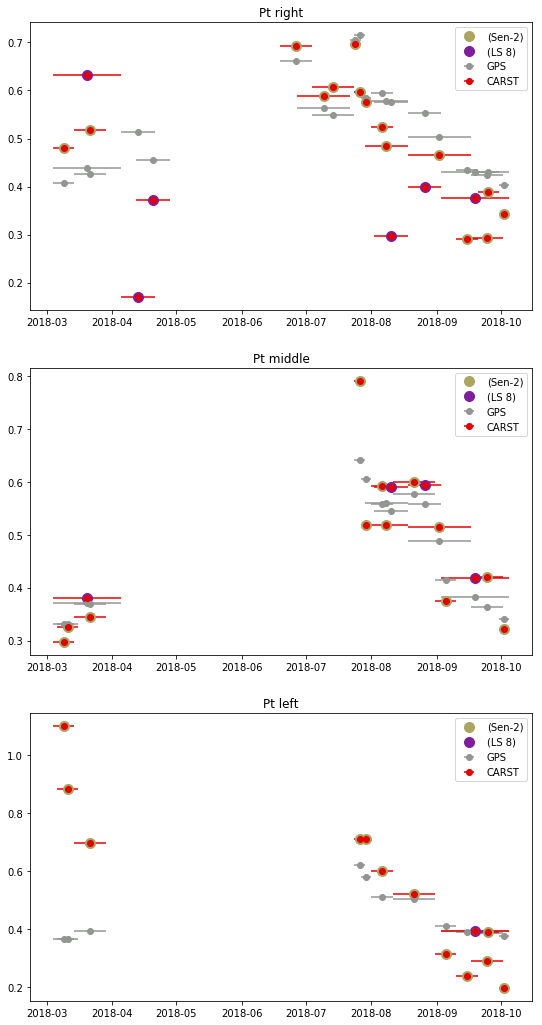

In [192]:
# plt.plot(pt0['date1_obj'], pt0['velocity (m/d)'])
plt.figure(figsize=(9, 18))
plt.subplot(3,1,1)
plt.errorbar(pt0['datec_obj'].values, pt0['velocity (m/d)'].values, xerr=pt0['dated_obj'].values, fmt='o', color='xkcd:gray', label='GPS')
plt.errorbar(pt0['datec_obj'].values, pt0['carst_velo (m/d)'].values, xerr=pt0['dated_obj'].values, fmt='o', color='xkcd:red', label='CARST')
plt.plot(pt0.loc[pt0['sat_tag'] == 'Sen2-Ob114', ['datec_obj']].values, pt0.loc[pt0['sat_tag'] == 'Sen2-Ob114', ['carst_velo (m/d)']].values, 'o', color='xkcd:khaki', markersize=10, label='(Sen-2)')
plt.plot(pt0.loc[pt0['sat_tag'] == 'Sen2-Orb14', ['datec_obj']].values, pt0.loc[pt0['sat_tag'] == 'Sen2-Orb14', ['carst_velo (m/d)']].values, 'o', color='xkcd:khaki', markersize=10)
plt.plot(pt0.loc[pt0['sat_tag'] == 'LS8-061018', ['datec_obj']].values, pt0.loc[pt0['sat_tag'] == 'LS8-061018', ['carst_velo (m/d)']].values, 'o', color='xkcd:purple', markersize=10, label='(LS 8)')
plt.plot(pt0.loc[pt0['sat_tag'] == 'LS8-062017', ['datec_obj']].values, pt0.loc[pt0['sat_tag'] == 'LS8-062017', ['carst_velo (m/d)']].values, 'o', color='xkcd:purple', markersize=10)
plt.legend()
plt.title('Pt right')
plt.subplot(3,1,2)
plt.errorbar(pt1['datec_obj'].values, pt1['velocity (m/d)'].values, xerr=pt1['dated_obj'].values, fmt='o', color='xkcd:gray', label='GPS')
plt.errorbar(pt1['datec_obj'].values, pt1['carst_velo (m/d)'].values, xerr=pt1['dated_obj'].values, fmt='o', color='xkcd:red', label='CARST')
plt.plot(pt1.loc[pt1['sat_tag'] == 'Sen2-Ob114', ['datec_obj']].values, pt1.loc[pt1['sat_tag'] == 'Sen2-Ob114', ['carst_velo (m/d)']].values, 'o', color='xkcd:khaki', markersize=10, label='(Sen-2)')
plt.plot(pt1.loc[pt1['sat_tag'] == 'Sen2-Orb14', ['datec_obj']].values, pt1.loc[pt1['sat_tag'] == 'Sen2-Orb14', ['carst_velo (m/d)']].values, 'o', color='xkcd:khaki', markersize=10)
plt.plot(pt1.loc[pt1['sat_tag'] == 'LS8-061018', ['datec_obj']].values, pt1.loc[pt1['sat_tag'] == 'LS8-061018', ['carst_velo (m/d)']].values, 'o', color='xkcd:purple', markersize=10, label='(LS 8)')
plt.plot(pt1.loc[pt1['sat_tag'] == 'LS8-062017', ['datec_obj']].values, pt1.loc[pt1['sat_tag'] == 'LS8-062017', ['carst_velo (m/d)']].values, 'o', color='xkcd:purple', markersize=10)
plt.legend()
plt.title('Pt middle')
plt.subplot(3,1,3)
plt.errorbar(pt2['datec_obj'].values, pt2['velocity (m/d)'].values, xerr=pt2['dated_obj'].values, fmt='o', color='xkcd:gray', label='GPS')
plt.errorbar(pt2['datec_obj'].values, pt2['carst_velo (m/d)'].values, xerr=pt2['dated_obj'].values, fmt='o', color='xkcd:red', label='CARST')
plt.plot(pt2.loc[pt2['sat_tag'] == 'Sen2-Ob114', ['datec_obj']].values, pt2.loc[pt2['sat_tag'] == 'Sen2-Ob114', ['carst_velo (m/d)']].values, 'o', color='xkcd:khaki', markersize=10, label='(Sen-2)')
plt.plot(pt2.loc[pt2['sat_tag'] == 'Sen2-Orb14', ['datec_obj']].values, pt2.loc[pt2['sat_tag'] == 'Sen2-Orb14', ['carst_velo (m/d)']].values, 'o', color='xkcd:khaki', markersize=10)
plt.plot(pt2.loc[pt2['sat_tag'] == 'LS8-061018', ['datec_obj']].values, pt2.loc[pt2['sat_tag'] == 'LS8-061018', ['carst_velo (m/d)']].values, 'o', color='xkcd:purple', markersize=10, label='(LS 8)')
plt.plot(pt2.loc[pt2['sat_tag'] == 'LS8-062017', ['datec_obj']].values, pt2.loc[pt2['sat_tag'] == 'LS8-062017', ['carst_velo (m/d)']].values, 'o', color='xkcd:purple', markersize=10)
plt.legend()
plt.title('Pt left')
# plt.errorbar(pt0['datec_obj'], pt0['velocity (m/d)'], xerr=pt0['dated_obj'])